<a href="https://colab.research.google.com/github/jvishnuvardhan/TF_Lite/blob/master/MNIST_float_Interpreter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-nightly

     |████████████████████████████████| 520.8MB 34kB/s 
     |████████████████████████████████| 2.9MB 50.1MB/s 
     |████████████████████████████████| 460kB 51.9MB/s 


In [0]:
import tensorflow as tf
import imageio as io
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
# 2.2.0-dev20200218

2.2.0-dev20200505


In [0]:
# Get dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Cast x_train & x_test to float32.
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28), name='input'),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='output')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                7808      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 8,138
Trainable params: 8,138
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))
# tf.saved_model.save(model, 'mnist')

Epoch 1/3
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5996 - accuracy: 0.8115 - val_loss: 0.2379 - val_accuracy: 0.9314
Epoch 2/3
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1952 - accuracy: 0.9426 - val_loss: 0.1524 - val_accuracy: 0.9565
Epoch 3/3
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1396 - accuracy: 0.9597 - val_loss: 0.1123 - val_accuracy: 0.9671


[[2.4867633e-05 3.7307094e-04 5.3559383e-04 9.0884592e-04 6.2747844e-05
  4.1735744e-05 4.6215700e-06 9.9757737e-01 1.3587481e-04 3.3513855e-04]]


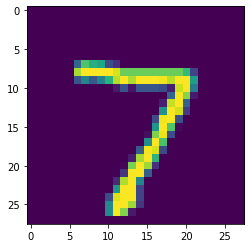

In [0]:
# Run the model with TensorFlow to get expected results.
input_data = x_test[0:1]
plt.imshow(input_data[0])
expected = model.predict(input_data)
print(expected)

In [0]:
# Convert model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("mnist_lstm_f32.tflite", "wb").write(tflite_model)

45016

In [0]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="mnist_lstm_f32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()
print(output_details)

interpreter.set_tensor(input_details[0]["index"], input_data)
interpreter.invoke()
result = interpreter.get_tensor(output_details[0]["index"])
print(result)

# Assert if the result of TFLite model is consistent with the TF model.
np.testing.assert_almost_equal(expected, result,decimal=5)
print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

[{'name': 'input', 'index': 0, 'shape': array([ 1, 28, 28], dtype=int32), 'shape_signature': array([-1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 37, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[2.4867595e-05 3.7307086e-04 5.3559343e-04 9.0884574e-04 6.2747808e-05
  4.1735715e-05 4.6215669e-06 9.9757761e-01 1.3587472e-04 3.3513849e-04]]
Done. The result of TensorFlow matches the result of TensorFlow Lite.
